In [44]:
#svm_model.ipynb
#
#by Joe Hahn
#joe.hahn@oracle.com
#5 July 2018
#
#train svm model

In [45]:
#set system parameters
x_half_width = 0.5
radius = 3.5
box_half_width = 7.1
jitter = 1.0
rn_seed = 13
initial_id = 0

In [74]:
#start time
import time as tm
time_start = tm.time()

In [76]:
#generate smallish sample training data...so that model hyperparameters can be tuned quickly
N_dots = 20000
import numpy as np
rn_state = np.random.RandomState(seed=rn_seed)
from helper_fns import *
train = make_xo_df(N_dots, initial_id, x_half_width, radius, box_half_width, jitter)
train.tail()

,id,x,y,r,angle,class,X_score,O_score,B_score
record,,,,,,,,,
19995,19995,-0.126814,-8.054713,8.055711,-1.586539,B,0.0,0.0,1.0
19996,19996,-2.579107,6.295252,6.803087,1.959629,B,0.0,0.0,1.0
19997,19997,5.329664,-2.013377,5.697280,-0.361195,B,0.0,0.0,1.0
19998,19998,0.674538,8.340765,8.367996,1.490100,B,0.0,0.0,1.0
19999,19999,7.627864,-1.446836,7.763868,-0.187451,B,0.0,0.0,1.0


In [77]:
#prep plots
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
sns.set(font_scale=1.5, font='DejaVu Sans')

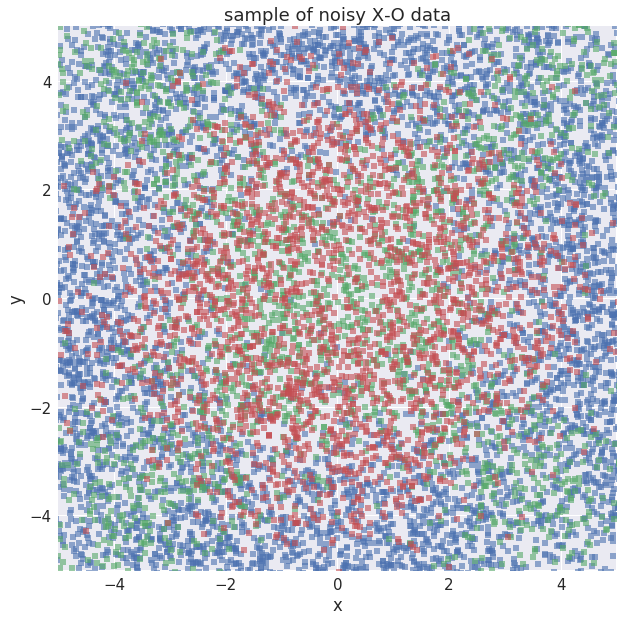

In [78]:
#scatterplot of noisy training data
df = train
xy_rng = (-5, 5)
sz = 30
f, ax = plt.subplots(figsize=(10,10))
lbl = 'B'
idx = (df['class'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
lbl = 'X'
idx = (df['class'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
lbl = 'O'
idx = (df['class'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
p = ax.set_title('sample of noisy X-O data')
p = ax.set_xlabel('x')
p = ax.set_ylabel('y')
p = ax.set_xlim(xy_rng)
p = ax.set_ylim(xy_rng)
plt.savefig('figs/training_data.png')

In [79]:
#check class balance
cols = ['id', 'class']
N = train[cols].groupby('class').count().sort_values('id')
N

,id
class,
O,2552
X,2640
B,14808


In [80]:
#rebalance training data
idx_O = (train['class'] == 'O')
idx_X = (train['class'] == 'X')
idx_B = (train['class'] == 'B')
train_balanced = train[idx_O].append(train[idx_X]).append(train[idx_B].sample(n=idx_O.sum()))
train_balanced[cols].groupby('class').count()

,id
class,
B,2552
O,2552
X,2640


In [81]:
#get features x and target variable y
x_cols = ['x', 'y']
y_col = 'class'
x = train_balanced[x_cols]
y = train_balanced[y_col]

In [52]:
#grid-search across hyperparameters, executed in parallel on all available cpus (4 cpus on m4.xlarge)
#this takes several minutes...
from sklearn.svm import SVC
model = SVC(kernel='rbf', probability=True)
from sklearn.model_selection import GridSearchCV
Cs = [0.001, 0.01, 0.1, 1.0, 10.0]
gammas = [0.001, 0.001, 0.01, 0.1, 1.0]
hperparameters = {'C':Cs, 'gamma':gammas}
model_grid = GridSearchCV(model, hperparameters, n_jobs=-1).fit(x, y)

In [82]:
#GridSearchCV's recommended model and hyperparameters
model = model_grid.best_estimator_
best_params_ = model_grid.best_params_
C = best_params_['C']
gamma =  best_params_['gamma']
best_score = model_grid.best_score_
print best_score
print best_params_
print C, gamma
#model_grid.cv_results_

0.6726757661601854
{'C': 0.1, 'gamma': 1.0}
0.1 1.0


In [64]:
#now train SVC model on x10 larger dataset
N_dots *= 5
train = make_xo_df(N_dots, initial_id, x_half_width, radius, box_half_width, jitter)
print train.shape
idx_O = (train['class'] == 'O')
idx_X = (train['class'] == 'X')
idx_B = (train['class'] == 'B')
train_balanced = train[idx_O].append(train[idx_X]).append(train[idx_B].sample(n=idx_O.sum()))
print train_balanced[cols].groupby('class').count()
x = train_balanced[x_cols]
y = train_balanced[y_col]
model = SVC(kernel='rbf', C=C, gamma=gamma, probability=True).fit(x, y)

(75000, 9)
         id
class      
B      9591
O      9591
X      9984


In [83]:
#generate predictions on testing dataset
N_dots = 20000
test = make_xo_df(N_dots, initial_id, x_half_width, radius, box_half_width, jitter)
x = test[x_cols]
test['class_pred'] = model.predict(x)
test.head()

,id,x,y,r,angle,class,X_score,O_score,B_score,class_pred
record,,,,,,,,,,
0,0,1.070803,4.072000,4.210440,1.313651,B,0.0,0.0,1.0,O
1,1,1.395233,-4.684341,4.887711,-1.281313,B,0.0,0.0,1.0,B
2,2,1.424840,-6.261044,6.421125,-1.347035,B,0.0,0.0,1.0,B
3,3,-1.017002,-5.639369,5.730338,-1.749218,B,0.0,0.0,1.0,B
4,4,-1.343126,4.020131,4.238566,1.893237,O,0.0,1.0,0.0,O


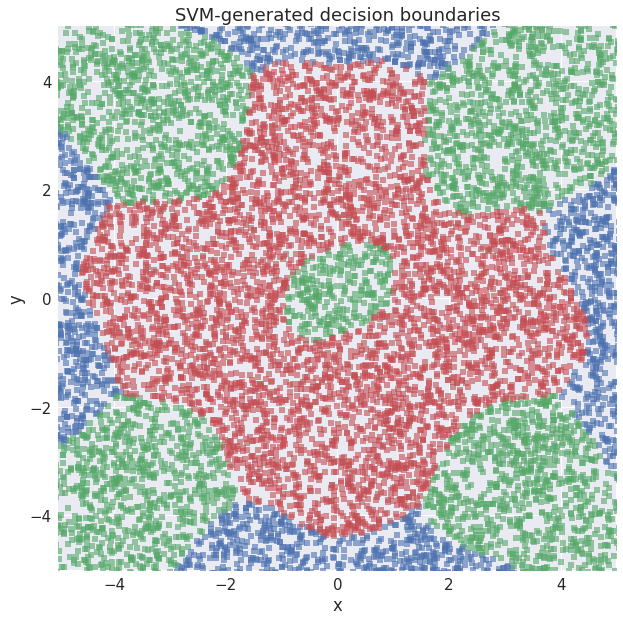

In [84]:
#scatterplot showing model's predicted decision boundaries
df = test
xy_rng = (-5, 5)
sz = 30
f, ax = plt.subplots(figsize=(10,10))
lbl = 'B'
idx = (df['class_pred'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
lbl = 'X'
idx = (df['class_pred'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
lbl = 'O'
idx = (df['class_pred'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
p = ax.set_title('SVM-generated decision boundaries')
p = ax.set_xlabel('x')
p = ax.set_ylabel('y')
p = ax.set_xlim(xy_rng)
p = ax.set_ylim(xy_rng)
plt.savefig('figs/svm_decision_boundary.png')

In [85]:
#model accuracy
idx = (test['class'] == test['class_pred'])
accuracy = idx.sum()*1.0/len(idx)
print 'model accuracy = ', accuracy

model accuracy =  0.69925


In [86]:
#done
time_stop = tm.time()
print 'execution time (minutes) = ', (time_stop - time_start)/60.0

execution time (minutes) =  1.33679494858
